# Sparse Bayes Model

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('ee-train.csv')
test = pd.read_csv('ee-test.csv')

In [3]:
# define a function used to get the design matrix
def get_PHI(x):
    N = len(x)
    ones = np.ones(N).reshape(N, 1)
    PHI = np.concatenate((ones,x), axis=1)
    return PHI

# define a function used to get the accuracy
def get_accuracy(y, y_pred):
    if y.ndim == 1:
        y = y.reshape(-1,1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
    SS_tot = ((y - y.mean()) ** 2).sum()
    SS_res = ((y - y_pred) ** 2).sum()
    accuracy = 1 - SS_res / SS_tot
    return accuracy
 
# define a function used to get the root mean squared error
def get_rms(y, y_pred):
    if y.ndim == 1:
        y = y.reshape(-1,1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1,1)
    err = np.sqrt(np.mean((y-y_pred)**2))
    return err

# define a function used to get the prediction
def predict(target_PHI, weights):
    
    prediction = np.dot(target_PHI, weights)
    
    return prediction

In [4]:
# pre-processing
x_train = np.array(train.iloc[:,:-1]).astype(float)
y_train = np.array(train.iloc[:,-1]).astype(float)
x_test = np.array(test.iloc[:,:-1]).astype(float)
y_test = np.array(test.iloc[:,-1]).astype(float)
PHI_train = get_PHI(x_train)
PHI_test = get_PHI(x_test)

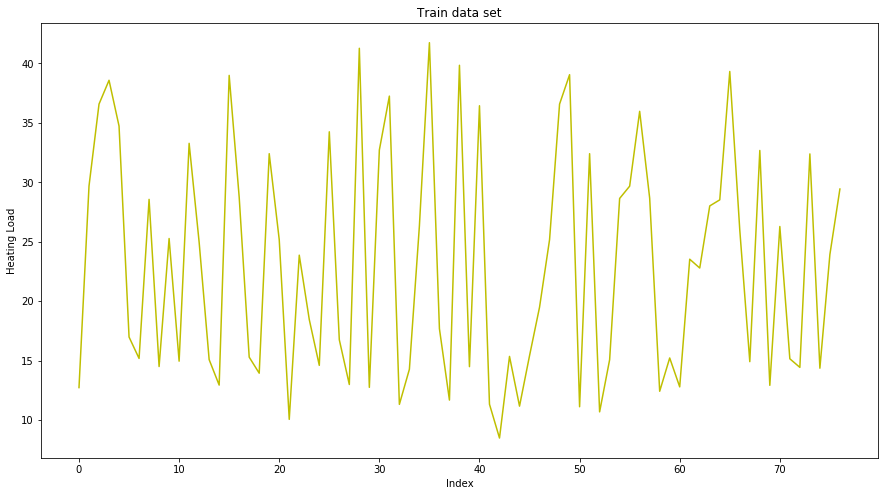

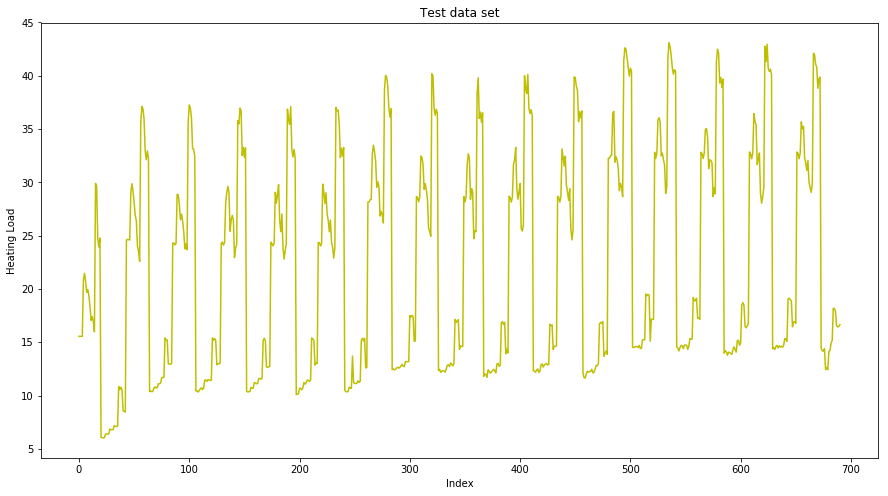

In [5]:
# plot train data set
plt.figure(figsize=(15,8))
plt.plot(np.arange(len(y_train)), y_train, c = 'y')
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Train data set')
plt.show()

# plot test data set
plt.figure(figsize=(15,8))
plt.plot(np.arange(len(y_test)), y_test, c = 'y')
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Test data set')
plt.show()

### supplied code 

from my professor @Mike Tipping

http://www.miketipping.com

In [6]:
from pysparsebayes import (basis,settings,sparsebayes)

iterations = 500
monIter    = 10 # Print output summary every set of these iterations
diagLevel  = 2 # Verbosity of diagnostics (3 tells you about every add/delete/re-estimate)
isNoiseFixed = False # Can try changing this - set to False to infer the noise level
noiseInit   = 1 # Initial value for noise std. dev. (or constant if noise is fixed)

# Define our options
UserOptions = settings.Options(setIterations=iterations, 
                               setMonitor=monIter,
                               setDiagnostic=diagLevel, 
                               setFixedNoise=isNoiseFixed)

# Set initial noise guess (or fixed value)
ParameterInit = settings.ParameterInits(setNoise=noiseInit)

# Run the inference algorithm
Results = sparsebayes.inference(PHI_train,y_train,Options=UserOptions,ParamSets=ParameterInit)

    Initialising with maximally aligned basis vector (5)
    Initial alpha = [2.14187997e-05]

       10> L = -1.811461	 Gamma = 3.89 (M = 4) s = 3.246
    ** Stopping at iteration 16 (Max_delta_ml=[1.2332069e-12]) **
      16> L = -1.810925	 Gamma = 3.90 (M = 4)


In [7]:
# get accuracy and rms
y_train_pred = np.dot(PHI_train[:,Results.Used], Results.PosteriorMu)
y_test_pred = np.dot(PHI_test[:,Results.Used], Results.PosteriorMu)

print('Sparse Bayesian Model accuracy on train data set is', get_accuracy(y_train, y_train_pred)*100, '%')
print('Sparse Bayesian Model accuracy on test data set is', get_accuracy(y_test, y_test_pred)*100, '%')

print('Sparse Bayesian Model rms on train data set is', get_rms(y_train, y_train_pred))
print('Sparse Bayesian Model rms on test data set is', get_rms(y_test, y_test_pred))

Sparse Bayesian Model accuracy on train data set is 89.45770931315545 %
Sparse Bayesian Model accuracy on test data set is 89.87517149837598 %
Sparse Bayesian Model rms on train data set is 3.161760115821984
Sparse Bayesian Model rms on test data set is 3.219442414514812


### Own implementation

without prune

In [8]:
def Sparse_Bayes_Regression_1(PHI, y, iterations = 500, minval = 1e-15):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    N,M = PHI.shape
    PHI = PHI.T
    y = y.T

    alpha_0 = 1.0 / (PHI ** 2).mean()
    alph = np.maximum(alpha_0, minval) * np.ones((1, M))
    
    # noise variance
    SY = (y ** 2).mean()
    
    weight = np.zeros((1, M))

    xx = np.dot(PHI, PHI.T)
    yx = np.dot(y, PHI.T)
    yy = (y ** 2).sum(axis=1)

    for i in range(iterations):
        # update weight
        SW = xx + np.diag(1.0 / alph[0])
        inv_SW = np.linalg.pinv(SW)
        weight = np.dot(yx, inv_SW)
        # update gain
        gain = np.diag(np.dot(xx, inv_SW)).transpose()
        gain = np.maximum(gain, minval)
        # update noise variance
        SY = (yy.sum() - (weight * yx).sum()) / N
        # update alpha
        ww = (weight ** 2).sum(axis=0)
        alph = np.sqrt(alph * (ww / SY) / gain)
        alph = np.maximum(alph, minval)

    return weight.T  

with prune

In [9]:
def Sparse_Bayes_Regression_2(PHI, y, iterations = 500, minval = 1e-15, 
                              prune_threshold = 1e-10, converge_threshold = 1e-10):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    N,M = PHI.shape
    PHI = PHI.T
    y = y.T

    alpha_0 = 1.0 / (PHI ** 2).mean()
    alph = np.maximum(alpha_0, minval) * np.ones((1, M))
    
    # noise variance
    SY = (y ** 2).mean()
    
    weight = np.zeros((1, M))

    xx = np.dot(PHI, PHI.T)
    yx = np.dot(y, PHI.T)
    yy = (y ** 2).sum(axis=1)
    
    # used for prune
    old_alph = alph[:, :]  
    old_M = M
    valid_index = np.arange(M)
    
    for i in range(iterations):
        # update weight
        SW = xx + np.diag(1.0 / alph[0])
        inv_SW = np.linalg.pinv(SW)
        weight = np.dot(yx, inv_SW)
        # update gain
        gain = np.diag(np.dot(xx, inv_SW)).transpose()
        gain = np.maximum(gain, minval)
        # update noise variance
        SY = (yy.sum() - (weight * yx).sum()) / N
        # update alpha
        ww = (weight ** 2).sum(axis=0)
        alph = np.sqrt(alph * (ww / SY) / gain)
        
        # prune the dimensions with the estimated precision of the weight over threshold
        alph_all = alph[0] / alph.max()
        activate_index = alph_all > prune_threshold
        if np.sum(activate_index) < M:
            # update dimension size
            old_M = M
            M = np.sum(activate_index)
            # reduce the dimensions
            alph = alph[:, activate_index]
            weight = weight[:, activate_index]
            PHI = PHI[activate_index, :]
            yx = yx[:, activate_index]
            xx = xx[np.ix_(activate_index, activate_index)]
            # update valid index
            valid_index = valid_index[activate_index]
        
        # check for convergence
        if M == old_M:
            diff = np.max(np.abs(alph - old_alph))
            if diff < converge_threshold:
                break
                
        old_alph = alph[:, :]
                  
    return weight.T, valid_index


def Sparse_Bayes_Regression_predict(train_PHI, train_y, test_PHI, iterations = 500):
    weight, valid_index = Sparse_Bayes_Regression(train_PHI, train_y, iterations = iterations)
    pred = np.dot(test_PHI[:,valid_index], weight)
    
    return pred

In [10]:
# get accuracy and rms
weights2 = Sparse_Bayes_Regression_1(PHI_train, y_train, iterations = 500)
y_train_pred2 = predict(PHI_train, weights2)
y_test_pred2 = predict(PHI_test, weights2)

print('Sparse Bayes LR accuracy on train data set without prune is', 
      get_accuracy(y_train, y_train_pred2)*100, '%')
print('Sparse Bayes LR accuracy on test data set without prune is', 
      get_accuracy(y_test, y_test_pred2)*100, '%')

print('Gibbs Bayes LR rms on train data set without prune is', get_rms(y_train, y_train_pred2))
print('Gibbs Bayes LR rms on test data set without prune is', get_rms(y_test, y_test_pred2))

Sparse Bayes LR accuracy on train data set without prune is 89.45794594158824 %
Sparse Bayes LR accuracy on test data set without prune is 89.87560015269645 %
Gibbs Bayes LR rms on train data set without prune is 3.1617246317625134
Gibbs Bayes LR rms on test data set without prune is 3.2193742631131825


In [11]:
# get accuracy and rms
weights3, valid_index = Sparse_Bayes_Regression_2(PHI_train, y_train, iterations = 500)
y_train_pred3 = predict(PHI_train[:,valid_index], weights3)
y_test_pred3 = predict(PHI_test[:,valid_index], weights3)

print('Sparse Bayes LR accuracy on train data set with prune is', 
      get_accuracy(y_train, y_train_pred3)*100, '%')
print('Sparse Bayes LR accuracy on test data set with prune is', 
      get_accuracy(y_test, y_test_pred3)*100, '%')

print('Sparse Bayes LR rms on train data set with prune is', get_rms(y_train, y_train_pred3))
print('Sparse Bayes LR rms on test data set with prune is', get_rms(y_test, y_test_pred3))

Sparse Bayes LR accuracy on train data set with prune is 89.457721893324 %
Sparse Bayes LR accuracy on test data set with prune is 89.87518359292397 %
Sparse Bayes LR rms on train data set with prune is 3.1617582293492874
Sparse Bayes LR rms on test data set with prune is 3.2194404916322474


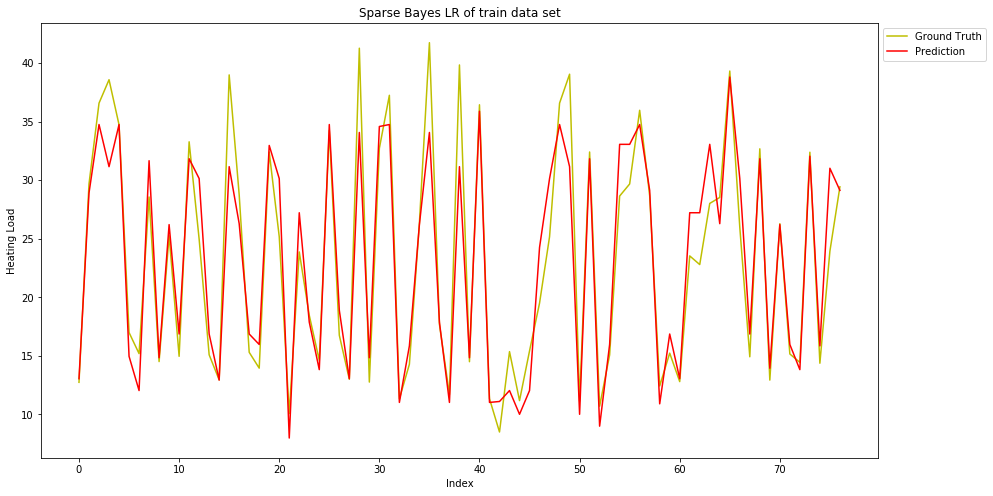

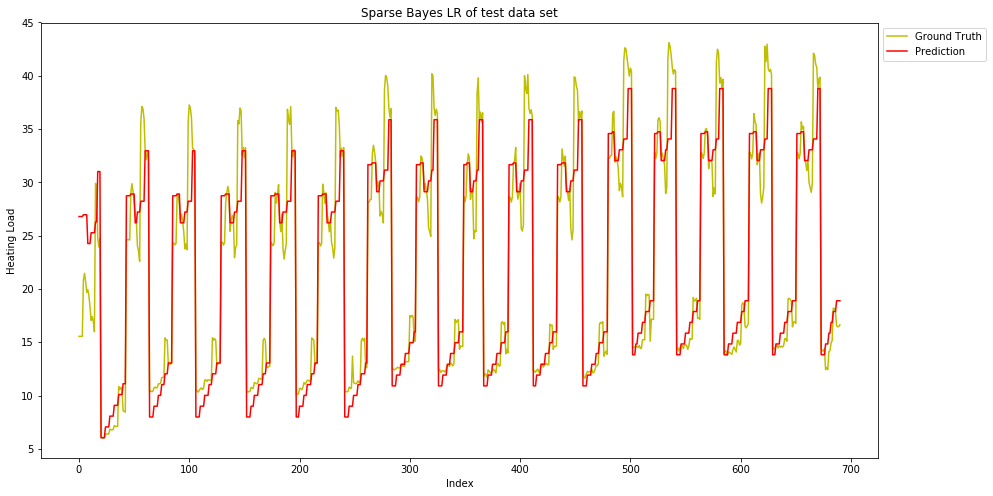

In [12]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(len(y_train)), y_train, c = 'y', label = 'Ground Truth')
plt.plot(np.arange(len(y_train)), y_train_pred3, c ='r', label = 'Prediction')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Sparse Bayes LR of train data set')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(np.arange(len(y_test)), y_test, c = 'y', label = 'Ground Truth')
plt.plot(np.arange(len(y_test)), y_test_pred3, c ='r', label = 'Prediction')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('Index')
plt.ylabel('Heating Load')
plt.title('Sparse Bayes LR of test data set')
plt.show()